# **ARRHYTMIA CLASSIFICATION**

# Yopi Julia Nurriski

# Impor Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import StepLR

# Pemuatan dan Pengolahan Data

In [ ]:
#Muat file CSV ke dalam DataFrame pandas.
train_df = pd.read_csv('/content/drive/MyDrive/metopen/mitbih_train.csv', header=None)

In [ ]:
#Kolom terakhir merupakan label data yang dijelaskan sebagai kategori dari 0 hingga 4,
#sehingga kita dapat menggunakannya sebagai target.

y_df = train_df.iloc[:, -1]
y_df = y_df.fillna(0)  # mengganti nilai NA dengan angka 0
y_df = y_df.astype('int')
y_df.head()

0    0
1    0
2    0
3    0
4    0
Name: 187, dtype: int64

In [ ]:
#Sisanya adalah titik data EKG, jadi kita akan menggunakannya sebagai fitur.

X_df = train_df.iloc[:, :-1]
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Konversi semua fitur menjadi tipe data float.

X_df = X_df.astype('float')
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Sebenarnya, kita tidak perlu mengkodekan target menggunakan one-hot encoding karena kita menggunakan cross-entropy loss, dan ini berjalan lebih efisien saat kita menyampaikan target sebagai indeks.
#Cetak nilai unik dalam target.

unique, counts = np.unique(y_df, return_counts=True)
print(f'unique values: {unique}')
print(f'counts: {counts}')

unique values: [0 1 2 3 4]
counts: [72471  2223  5788   641  6431]


In [ ]:
#Buat directory untuk memetakan indeks target ke nama kelas.

class_names = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

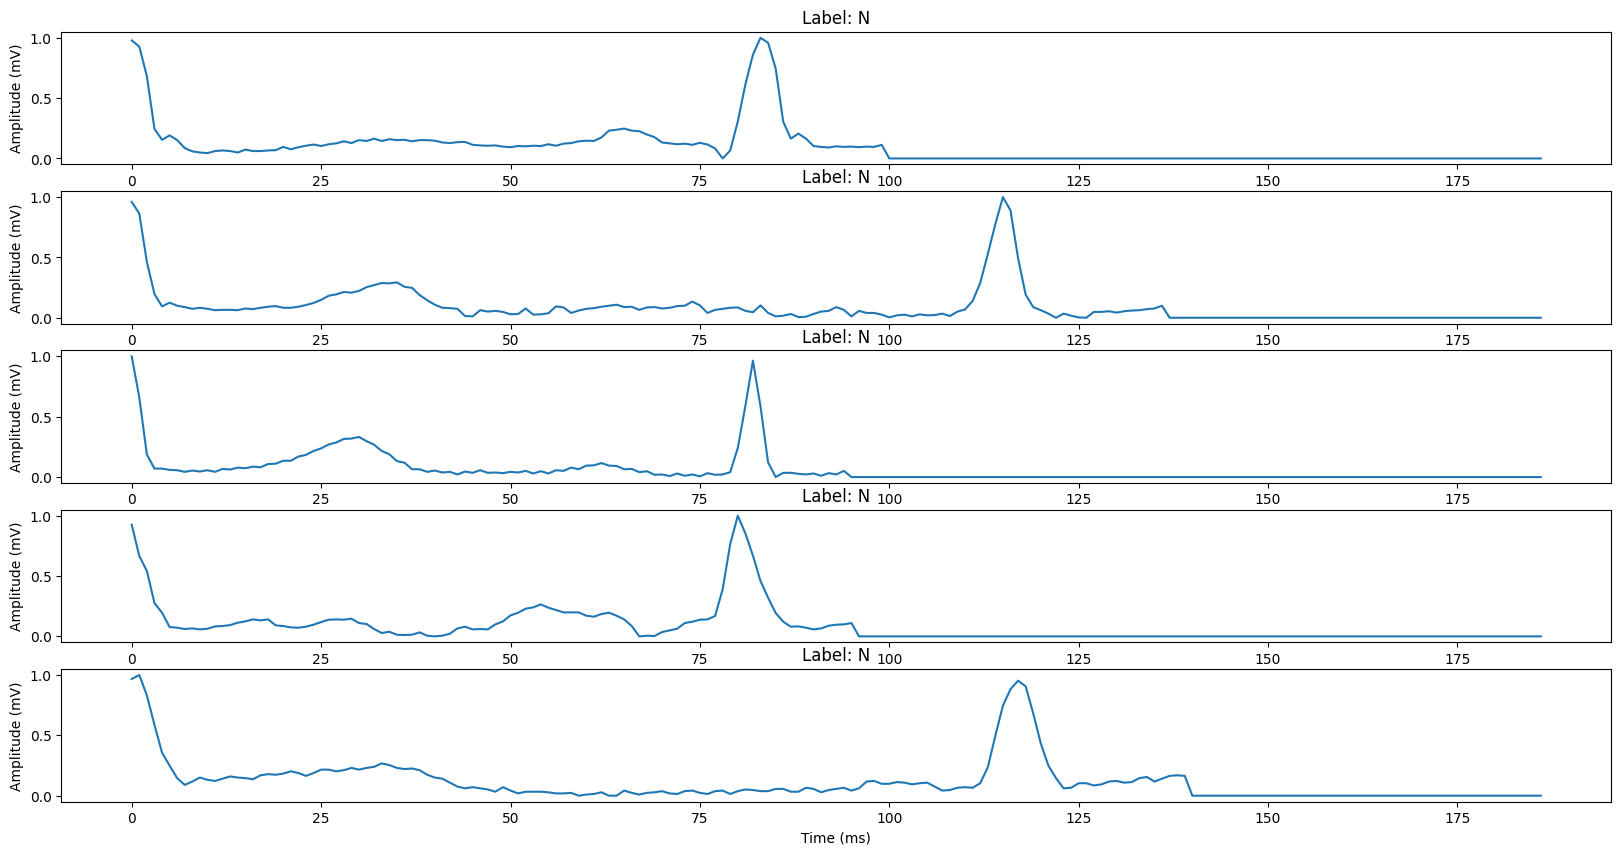

In [ ]:
#Gambarkan sinyal EKG pertama 5 dalam dataset beserta label mereka.

fig, ax = plt.subplots(5, 1, figsize=(20, 10))
for i in range(5):
    ax[i].plot(X_df.iloc[i, :])
    ax[i].set_title(f'Label: {class_names[y_df[i]]}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Amplitude (mV)')

In [ ]:
#Dimensi input adalah 187 dan dimensi output adalah 5. Kami ingin input menjadi (batch_size, 1, 187) dan output menjadi (batch_size, 5)
#karena input memiliki satu saluran (channel) dan output memiliki 5 kelas.

X_np = X_df.to_numpy()
X_np.shape

(87554, 187)

In [ ]:
#Kami ingin menambahkan dimensi saluran pada input.

X_np = X_np.reshape(-1, 1, 187)
X_np.shape

(87554, 1, 187)

In [ ]:
#Lakukan hal yang sama untuk target

y_np = y_df.to_numpy()
y_np.shape

(87554,)

In [ ]:
y_np = y_np.reshape(-1, 1)
y_np.shape

(87554, 1)

# Normalisasi Data

In [ ]:
#Sempurna, sekarang kita memiliki input dan target dalam bentuk yang benar.

X_mean = X_np.mean()
X_std = X_np.std()
X_max = X_np.max()
X_min = X_np.min()
print(f'mean before normalization: {X_mean}')
print(f'std: {X_std}')
print(f'max: {X_max}')

mean before normalization: 0.17428295254906354
std: 0.22632738719052128
max: 1.0


In [ ]:
#Kita perlu mengurangkan rata-rata dari data.

X_norm = X_np - X_mean

#
Kemudian, kalikan dengan 1/std agar deviasi standar menjadi 1.

X_norm *= 1/X_std

In [ ]:
print(X_norm.shape)
print(f'new mean is {X_norm.mean()}')
print(f'new std is {X_norm.std()}')

(87554, 1, 187)
new mean is 1.5088439287128576e-15
new std is 1.0000000000000004


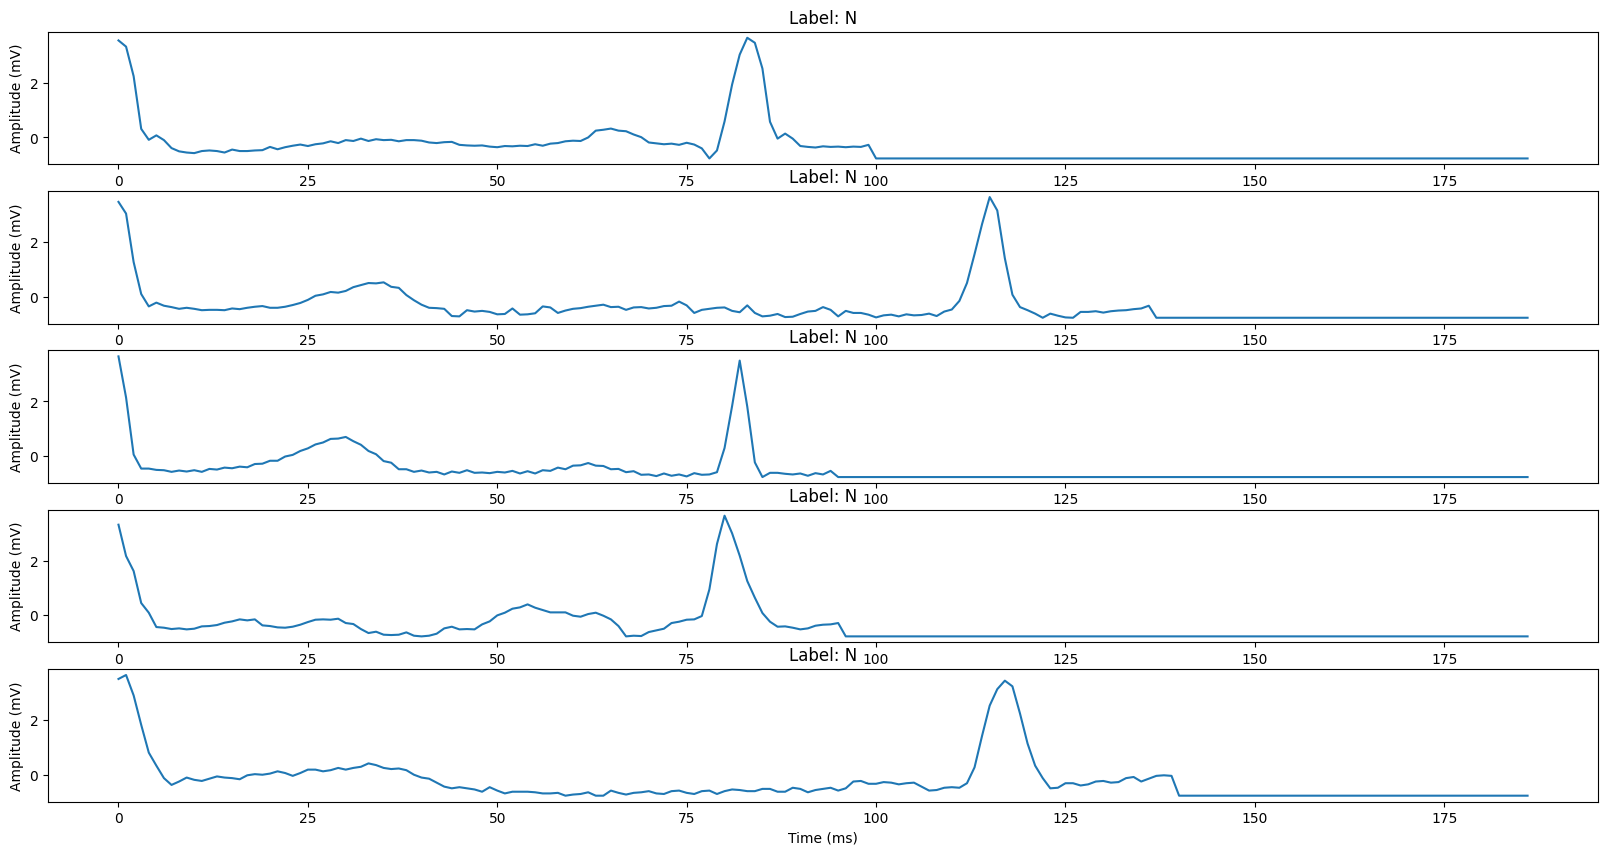

In [ ]:
#Sekarang, gambarkan data yang dinormalisasi.

fig, ax = plt.subplots(5, 1, figsize=(20, 10))
for i in range(5):
    ax[i].plot(X_norm[i, 0, :])
    ax[i].set_title(f'Label: {class_names[y_df[i]]}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Amplitude (mV)')

Text(0, 0.5, 'Amplitude (mV)')

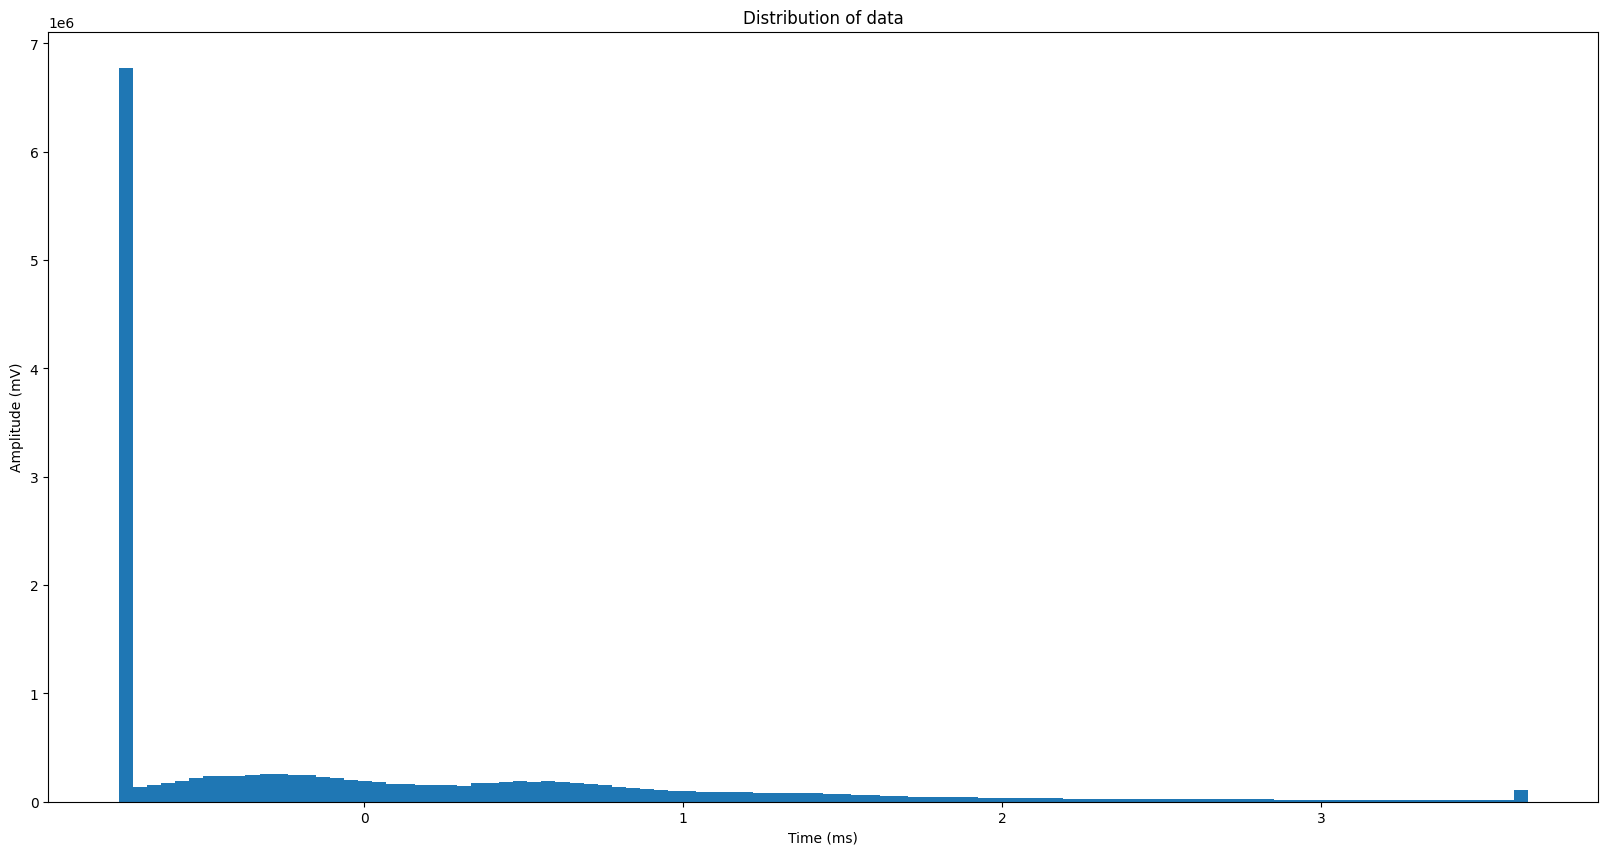

In [ ]:
#Sekarang, gambarkan distribusi data.

X_norm = np.nan_to_num(X_norm, nan=0, posinf=1e6, neginf=-1e6) # mengganti nilai NaN dengan 0 dan nilai inf dengan angka besar
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.hist(X_norm.flatten(), bins=100)
ax.set_title(f'Distribution of data')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (mV)')

In [ ]:
X_norm.shape #representing the input data as a sequence of 187 points

(87554, 1, 187)

In [ ]:
y_np.shape #representing the target as indices 0 to 4

(87554, 1)

# Menyimpan variabel yang dinormalisasi.

In [ ]:
#Menyimpan data yang dinormalisasi ke dalam file CSV.

np.savetxt('X_norm.csv', X_norm.squeeze(), delimiter=',')
np.savetxt('y_np.csv', y_np, delimiter=',')
# np.loadtxt('X_norm.csv', delimiter=',').shape

Memuat variabel yang dinormalisasi dari disk.

In [ ]:
X_norm = np.loadtxt('X_norm.csv', delimiter=',').reshape(-1, 1, 187)
y_np = np.loadtxt('y_np.csv', delimiter=',').reshape(-1, 1)

In [ ]:
print(X_norm.shape)
print(y_np.shape)

(87554, 1, 187)
(87554, 1)


In [ ]:
#change y_np data type to int
y_np = y_np.astype('int')
y_np.dtype

dtype('int64')

Kita membagi data menjadi set pelatihan dan validasi menggunakan scikit-learn.

In [ ]:
#shuffle the data and split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_norm, y_np, test_size=0.2, shuffle=True)

Sekarang kita periksa ketidakseimbangan kelas.

In [ ]:
#print the frequency of each class in the train and validation sets
print(f'Frequency of each class in the train set')
unique, counts = np.unique(y_train, return_counts=True)
for i in range(len(unique)):
    print(f'{class_names[unique[i]]}: {counts[i]}')

print(f'Frequency of each class in the validation set')
unique, counts = np.unique(y_val, return_counts=True)
for i in range(len(unique)):
    print(f'{class_names[unique[i]]}: {counts[i]}')

Frequency of each class in the train set
N: 57891
S: 1787
V: 4632
F: 523
Q: 5210
Frequency of each class in the validation set
N: 14580
S: 436
V: 1156
F: 118
Q: 1221


Kita mendefinisikan sebuah kamus hyperparameter.

In [ ]:
hyper_params = {'bs': 1024,
                                'lr': 1e-3,
                                'lr_decay': 0.3,
                                'epochs':50,
                                }

In [ ]:
#Kita mendefinisikan sebuah kamus hyperparameter.

train_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

In [ ]:
len(train_ds), len(val_ds)

(70043, 17511)

Kita menghitung bobot setiap kelas dengan membalik distribusinya dan melakukan normalisasi.

In [ ]:
#Distribusi kelas tidak merata, sehingga kita harus menentukan bobot untuk setiap kelas.
class_dist = np.unique(y_train, return_counts=True)[1] #
Indeks 1 mengembalikan jumlah (counts).
class_dist = class_dist/np.sum(class_dist) #Normalisasikan untuk mendapatkan nilai antara 0 dan 1.

#Normalisasikan bobot.

weights = 1/class_dist #
Balik (invert) untuk mengkompensasi ketidakseimbangan distribusi kelas
weights = weights/weights.sum() #Normalisasikan untuk mendapatkan nilai antara 0 dan 1.
weights, class_names

(array([0.00596319, 0.19318135, 0.0745283 , 0.66006707, 0.06626009]),
 {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'})

Kita berikan bobot yang telah dihitung pada setiap contoh dalam set pelatihan.







In [ ]:
#Dapatkan bobot untuk setiap contoh dalam dataset.

data_weights = np.zeros(y_train.shape[0]) #shape (m, )
for i in range(y_train.shape[0]): #Untuk setiap contoh, kita berikan bobot yang sesuai.
    data_weights[i] = weights[y_train[i, 0]]
data_weights[:10]

array([0.00596319, 0.00596319, 0.00596319, 0.06626009, 0.00596319,
       0.00596319, 0.00596319, 0.00596319, 0.00596319, 0.00596319])

Then we pass the weights to the WeightedRandomSampler to sample according to the normalized weights

In [ ]:
#data loader - we use the random weights sampler to balance the classes
train_dl = DataLoader(train_ds, batch_size=hyper_params['bs'], sampler=WeightedRandomSampler(weights=data_weights, num_samples= len(y_train), replacement=True))
val_dl = DataLoader(val_ds, batch_size=hyper_params['bs'])

Kemudian, kita lewatkan bobot ke WeightedRandomSampler untuk melakukan pengambilan sampel sesuai dengan bobot yang dinormalisasi.

In [ ]:
#Dapatkan distribusi kelas dalam dataloader.

for batch in train_dl:
    print(batch[1].shape)
    unique, counts = np.unique(batch[1], return_counts=True)
    for i in range(len(unique)):
        print(f'{class_names[unique[i]]}: {counts[i]}')
    break

torch.Size([1024, 1])
N: 200
S: 208
V: 195
F: 210
Q: 211


Kita bisa melihat bahwa distribusi sekarang hampir merata.

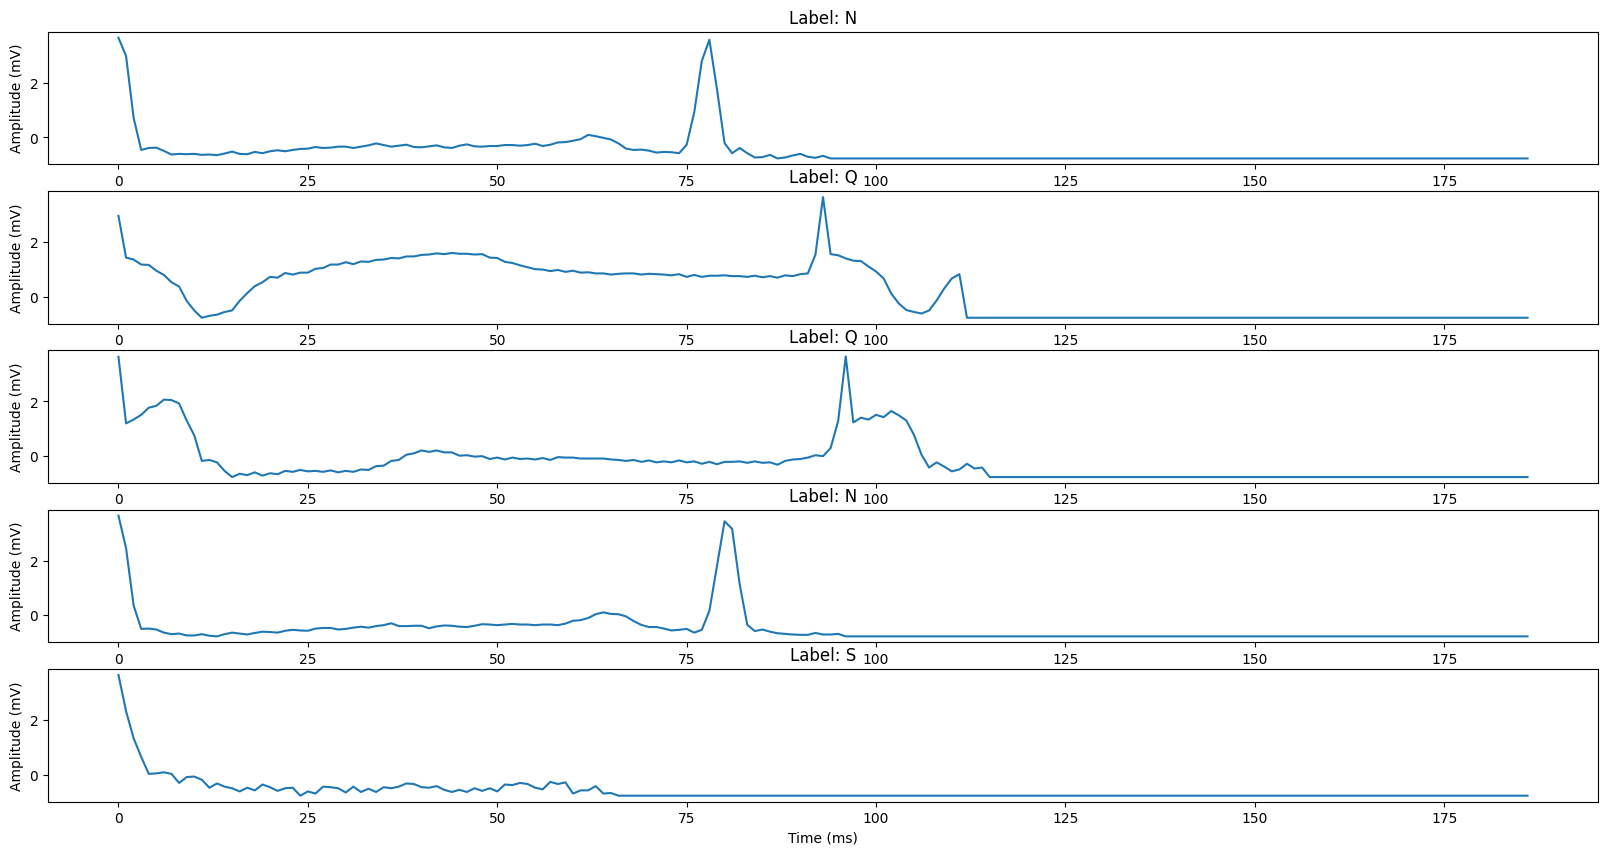

In [ ]:
#sample random batch from the train dataloader and plot the first 5 ecg signals in the batch

x, y = next(iter(train_dl))
fig, ax = plt.subplots(5, 1, figsize=(20, 10))
for i in range(5):
    ax[i].plot(x[i, 0, :])
    ax[i].set_title(f'Label: {class_names[y[i].item()]}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Amplitude (mV)')

# Network Architecture

Di sini, kita mendefinisikan arsitektur Network-in-network untuk memproses sinyal daripada menggunakan lapisan linear di akhir model untuk mengklasifikasikan sinyal. Kami menggunakan lapisan 1x1 Conv1d untuk menangkap korelasi dan global average pooling untuk mengurangi dimensi. Selain itu, saat melakukan eksperimen, saya menemukan bahwa aktivasi GELU bekerja lebih baik daripada RELU dalam kasus ini.

In [ ]:
#Buat beberapa blok konvolusional untuk digunakan dalam model.

def nin_block(in_channels, out_channels, kernel_size, padding, strides):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size, strides, padding),
        nn.BatchNorm1d(out_channels),
        nn.GELU(),
        nn.Conv1d(out_channels, out_channels, kernel_size=1), nn.GELU(),
        nn.Conv1d(out_channels, out_channels, kernel_size=1), nn.GELU(),
    )

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def get_model_with_focal_loss():
    return nn.Sequential(
        nin_block(1, 48, kernel_size=11, strides=4, padding=0),
        nn.MaxPool1d(3, stride=2),
        nin_block(48, 128, kernel_size=5, strides=1, padding=2),
        nn.MaxPool1d(3, stride=2),
        nin_block(128, 256, kernel_size=3, strides=1, padding=1),
        nn.MaxPool1d(3, stride=2),
        nn.Dropout(0.4),
        nin_block(256, 5, kernel_size=3, strides=1, padding=1),
        nn.AdaptiveAvgPool1d(1),
        nn.Flatten()
    )

In [ ]:
model = get_model_with_focal_loss()

In [ ]:
#Ukuran model dalam megabita (MB)

print(f'Model size: {sum(p.numel() for p in model.parameters() if p.requires_grad)*4/(1024**2)} MB')

#Jumlah parameter yang dapat dilatih.

print(f'Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Model size: 1.1599540710449219 MB
Number of trainable parameters: 304075


In [ ]:
#Mencari perangkat untuk menjalankan model tersebut

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
#
Memindahkan model ke perangkat.
model = model.to(device)

In [ ]:
class_names

{0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

Selama percobaan, saya menemukan bahwa jika saya mengatur beberapa bobot untuk beberapa kelas, modelnya menjadi lebih baik.

Dengan cara ini, saya memaksa model untuk mempelajari kelas-kelas yang sebelumnya tidak berhasil dilakukannya dengan baik.

In [ ]:
#loss function

criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 1.1, 2.5, 3, 1], dtype=torch.float, device=device)) #CE loss automatically uses indices as targets

In [ ]:
#optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['lr'])


In [ ]:
#lr_scheduler

lr_scheduler = StepLR(optimizer, step_size=10, gamma=hyper_params['lr_decay'], verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


Training function

In [ ]:
def train(model, criterion, optimizer, train_dl, val_dl, epochs, lr_scheduler: StepLR=None):
    """trains the model for the given number of epochs

    Args:
        model (nn.Module): nn model
        criterion (nn.CELoss): loss function
        optimizer (torch.optim): optimizer
        train_dl (Dataloader): training dataloader
        val_dl (Dataloader): validation dataloader
        epochs (int): number of epochs to train for
        lr_scheduler (StepLR): learning rate scheduler to adjust lr during training
    Returns:
        list of training losses and validation losses, best model parameters, best accuracy
    """
    train_losses = []
    val_losses = []
    best_model_params = deepcopy(model.state_dict())
    best_accuracy = 0.0
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-'*10)
        train_loss = 0
        val_loss = 0
        model.train() #set the model to training mode
        for x, y in train_dl: #x: (batch_size, 1, 187), y: (batch_size, 1)
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x) #the output shape is (batch_size, 5) so it's a distribution over the 5 classes
            loss = criterion(output, y.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*x.size(0)
        train_loss = train_loss/len(train_dl.dataset)
        train_losses.append(train_loss)
        lr_scheduler.step() #update the learning rate every n epochs
        model.eval() #set the model to evaluation mode
        corrects = 0 #in order to calculate accuracy we store the number of correct predictions
        for x, y in val_dl:
            x = x.to(device)
            y = y.to(device)
            output = model(x) #out shape: (batch_size, 5)
            loss = criterion(output, y.squeeze())
            val_loss += loss.item()*x.size(0)
            #calculate the number of correct predictions
            corrects += torch.sum(torch.argmax(output, dim=1) == y.squeeze()).item()
        val_loss = val_loss/len(val_dl.dataset)
        accuracy = corrects/len(val_dl.dataset)
        val_losses.append(val_loss)
        print(f'Train Loss: {train_loss:.4f} \t Val Loss: {val_loss:.4f} \t Val Accuracy: {accuracy:.4f}')
        #if the model performs better on the validation set, save the model parameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_params = deepcopy(model.state_dict())
    print('Finished Training and the best accuracy is: {:.4f}'.format(best_accuracy))
    return train_losses, val_losses, best_model_params, best_accuracy

In [ ]:
train_losses, val_losses, best_model_params, best_accuracy = train(model, criterion, optimizer, train_dl, val_dl, hyper_params['epochs'], lr_scheduler)

Epoch 1/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 1.2730 	 Val Loss: 1.4940 	 Val Accuracy: 0.8015
Epoch 2/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 1.0865 	 Val Loss: 1.5188 	 Val Accuracy: 0.7305
Epoch 3/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.9812 	 Val Loss: 1.5585 	 Val Accuracy: 0.0999
Epoch 4/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.8845 	 Val Loss: 1.5628 	 Val Accuracy: 0.1558
Epoch 5/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.8018 	 Val Loss: 1.4477 	 Val Accuracy: 0.4012
Epoch 6/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.6945 	 Val Loss: 1.1700 	 Val Accuracy: 0.7889
Epoch 7/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.5693 	 Val Loss: 0.8017 	 Val Accuracy: 0.8858
Epoch 8/50
----------
Adjusting learning rate of group 0 to 1.0000e-0

Model selesai melatih dengan akurasi validasi sebesar 98,7%!

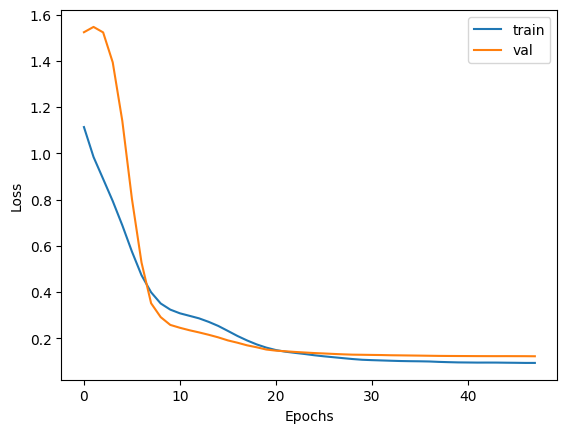

In [ ]:
#Gambar grafik kerugian pelatihan dan validasi dengan garis yang halus

plt.plot(np.convolve(train_losses, np.ones(3)/3, mode='valid'), label='train')
plt.plot(np.convolve(val_losses, np.ones(3)/3, mode='valid'), label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
#Muat parameter-model terbaik
model.load_state_dict(best_model_params)
#Simpan model ke dalam sebuah file
torch.save(model.state_dict(), f'best_model{best_accuracy:.2f}.pt')

In [ ]:
#Gunakan sel ini untuk memuat bobot dari penyimpanan.
model = get_model_with_focal_loss().to(device=device)
model.load_state_dict(torch.load('best_model0.99.pt'))

<All keys matched successfully>

In [ ]:
#confusion matrix function
def plot_cm(model, dl, categories, normalize='true'):
    #plot the confusion matrix
    model.eval()
    y_pred = []
    y_true = []
    for x, y in dl:
        x = x.to(device)
        y = y.to(device)
        output = model(x) #out shape: (batch_size, 5)
        y_pred.extend(torch.argmax(output, dim=1).cpu().numpy())
        y_true.extend(y.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    sns.heatmap(cm, annot=True, fmt= '.2f', cmap='Blues', xticklabels=categories.values(), yticklabels=categories.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(classification_report(y_true, y_pred, target_names=class_names.values()))

Mari tidak terlalu bersemangat, kita perlu memeriksa hasilnya dan memastikan model tidak menipu kita dengan mengabaikan kelas-kelas minor.

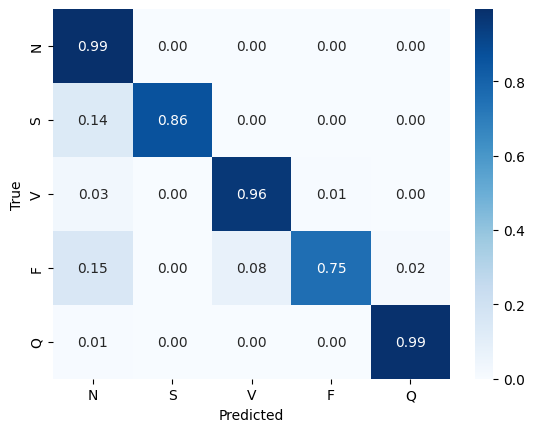

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     14580
           S       0.91      0.86      0.88       436
           V       0.97      0.96      0.96      1156
           F       0.86      0.75      0.80       118
           Q       0.99      0.99      0.99      1221

    accuracy                           0.99     17511
   macro avg       0.94      0.91      0.93     17511
weighted avg       0.99      0.99      0.99     17511



In [ ]:
#plot the confusion matrix using the validation set
plot_cm(model, val_dl, class_names)

Kita dapat melihat bahwa model berkinerja sangat baik pada set validasi.

True: V 	 Predicted: N


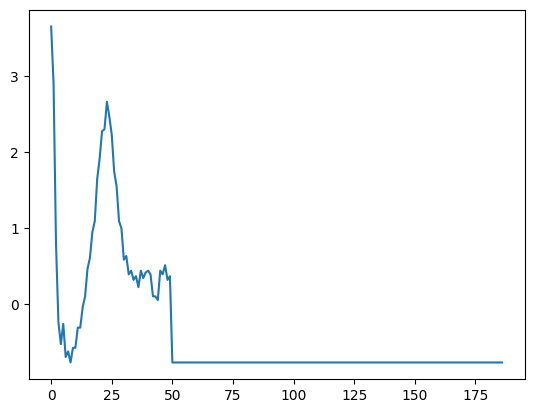

True: N 	 Predicted: Q


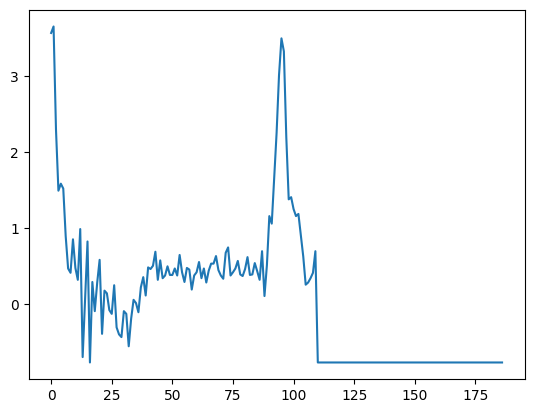

True: N 	 Predicted: V


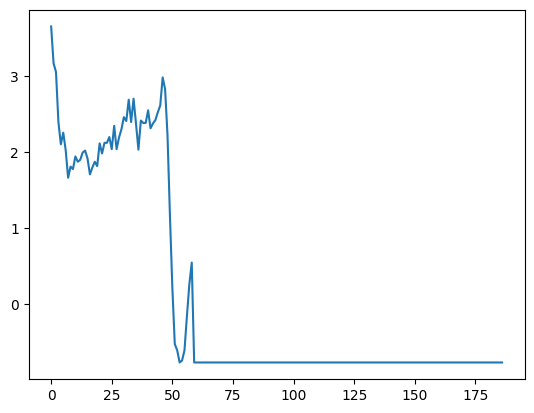

True: S 	 Predicted: N


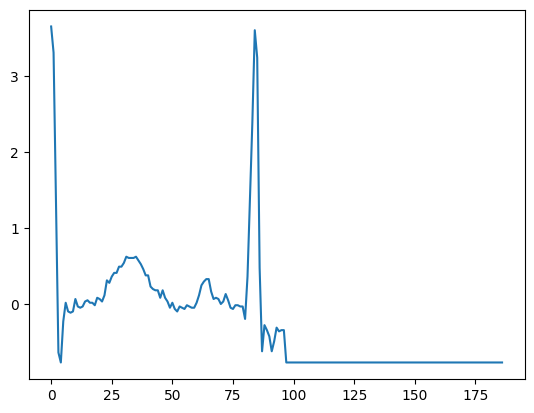

True: F 	 Predicted: V


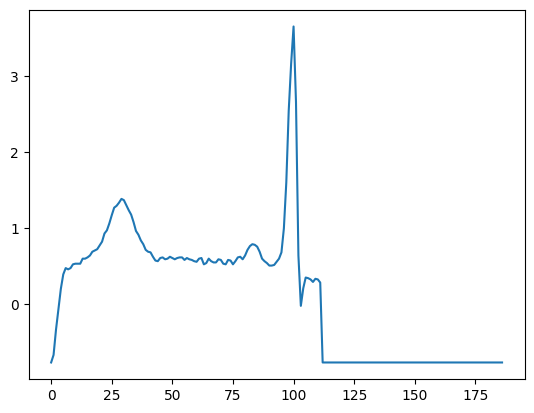

In [ ]:
#Visualisasikan prediksi yang salah oleh model.
model.eval()
count = 0
for x, y in val_dl:
    x = x.to(device)
    y = y.to(device)
    output = model(x) #out shape: (batch_size, 5)
    y_pred = torch.argmax(output, dim=1)
    for i in range(len(y_pred)):
        if y_pred[i] != y[i] and count < 5:
            print(f'True: {class_names[y[i].item()]} \t Predicted: {class_names[y_pred[i].item()]}')
            plt.plot(x[i, 0, :].cpu().numpy())
            plt.show()
            count += 1

Bagian ini menghitung akurasi model pada data uji.

In [ ]:
#Bagian ini memuat data uji dan menghitung akurasi pada set uji
test_df = pd.read_csv('/content/drive/MyDrive/metopen/mitbih_test.csv', header=None)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Kolom terakhir adalah label.
label_df = test_df.iloc[:, -1]
label_df = label_df.astype('int')
label_df.head()

0    0
1    0
2    0
3    0
4    0
Name: 187, dtype: int64

In [ ]:
#Sisa kolom-kolom lainnya adalah sinyal.
features_df = test_df.iloc[:, :-1]
features_df = features_df.astype('float32')
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Konversikan ke dalam larik numpy.
X_test_np = features_df.to_numpy()
y_test_np = label_df.to_numpy()

In [ ]:
X_test_np.shape, y_test_np.shape

((21892, 187), (21892,))

In [ ]:
#Kita harus mengubah bentuk data menjadi (batch_size, 1, 187) karena itu adalah bentuk yang diharapkan oleh model.

X_test_np = np.reshape(X_test_np, (X_test_np.shape[0], 1, X_test_np.shape[1]))
X_test_np.shape

(21892, 1, 187)

In [ ]:
y_test_np = np.reshape(y_test_np, (y_test_np.shape[0], 1))
y_test_np.shape

(21892, 1)

In [ ]:
#Kita harus normalisasi data
X_test_np = (X_test_np - X_test_np.mean())/X_test_np.std()
X_test_np[:5, 0, :5]

array([[ 3.664428  ,  2.5926797 , -0.27447614, -0.7691292 , -0.41187975],
       [ 3.2584245 ,  2.70626   ,  1.5856906 ,  0.83864427,  0.8548844 ],
       [ 2.4677598 ,  0.17251123, -0.7691292 , -0.23945646, -0.3179265 ],
       [ 3.664428  ,  3.267255  ,  2.2512314 ,  1.3275739 ,  0.24689431],
       [ 1.7600813 ,  1.0013181 ,  0.2871881 , -0.11451006, -0.7691292 ]],
      dtype=float32)

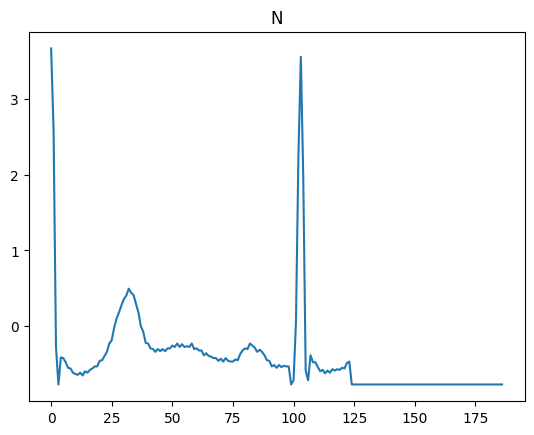

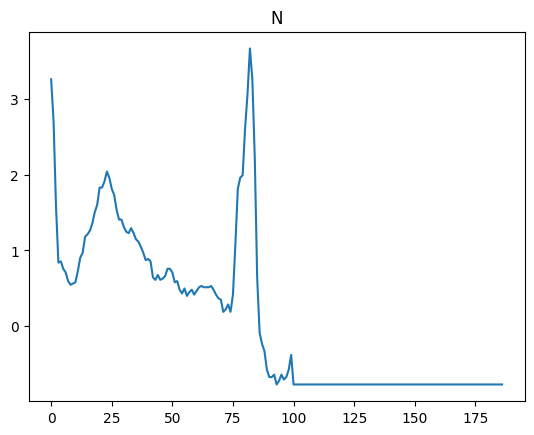

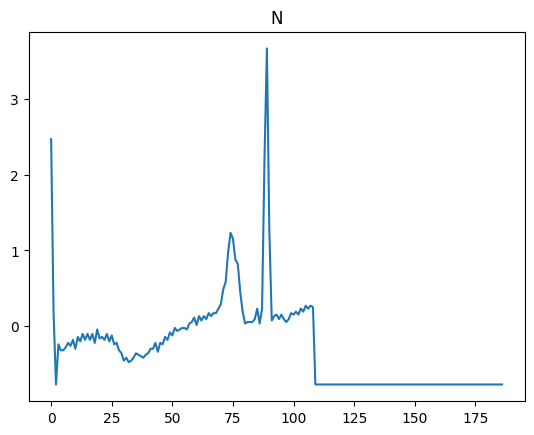

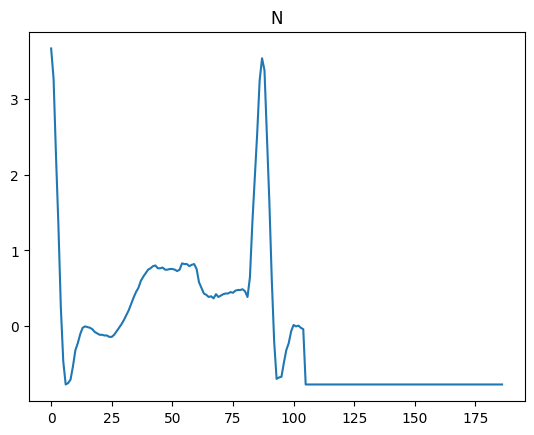

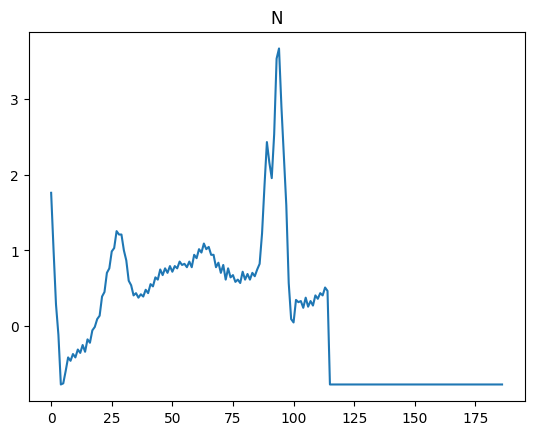

In [ ]:
#Visualisasikan lima sampel pertama.
for i in range(5):
    plt.plot(X_test_np[i, 0])
    plt.title(class_names[y_test_np[i, 0]])
    plt.show()

In [ ]:
print(f'test mean: {X_test_np.mean():.4f} \t test std: {X_test_np.std():.4f}')

test mean: 0.0000 	 test std: 1.0000


In [ ]:
#Cetak jumlah sampel pada setiap kelas.
for i in range(5):
    print(f'class {i}: {np.sum(y_test_np == i)}')

class 0: 18118
class 1: 556
class 2: 1448
class 3: 162
class 4: 1608


In [ ]:
#Membuat dataset
test_ds = TensorDataset(torch.from_numpy(X_test_np), torch.from_numpy(y_test_np))
test_dl = DataLoader(test_ds, batch_size=hyper_params['bs'], shuffle=False)

In [ ]:
#Gunakan sel ini untuk memuat bobot dari penyimpanan.
model = get_model_with_focal_loss().to(device=device)
model.load_state_dict(torch.load('best_model0.99.pt'))

<All keys matched successfully>

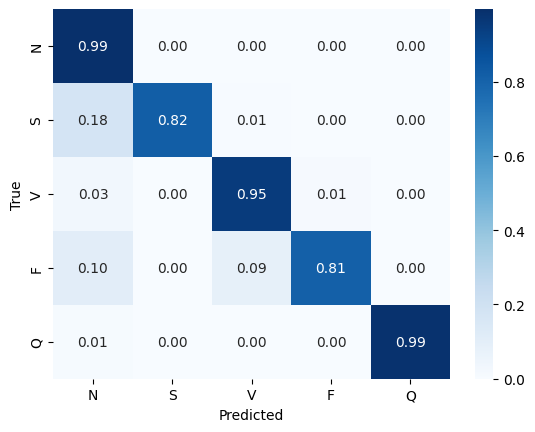

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     18118
           S       0.91      0.82      0.86       556
           V       0.96      0.95      0.96      1448
           F       0.81      0.81      0.81       162
           Q       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.93      0.91      0.92     21892
weighted avg       0.99      0.99      0.99     21892



In [ ]:
#Hitung sensitivitas dan spesifisitas untuk setiap kelas menggunakan scikit-learn.

plot_cm(model, test_dl, class_names)

In [ ]:
def calculate_accuracy(model, dataloader):
    model.eval()
    corrects = 0
    total_samples = 0
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        y_pred = torch.argmax(output, dim=1)
        corrects += torch.sum(y_pred == y.squeeze()).item()
        total_samples += y.size(0)
    accuracy = corrects / total_samples
    return accuracy

# Training
train_accuracy = calculate_accuracy(model, train_dl)
print(f'Training Accuracy: {train_accuracy:.4f}')

# Testing
test_accuracy = calculate_accuracy(model, test_dl)
print(f'Testing Accuracy: {test_accuracy:.4f}')

Di sini kita melihat bahwa model berkinerja sebaik yang dilakukan pada set validasi, ini menunjukkan bahwa model telah belajar untuk generalisasi! Kami memiliki akurasi total sebesar 99% pada data uji, dan kami juga perlu memperhatikan presisi dan recall. Meskipun kita tidak memiliki angka seperti yang kita miliki dengan set validasi, namun hasilnya tetap sangat baik